In [75]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from math import sqrt

In [26]:
df=pd.read_csv('monthly_milk_production.csv')

In [27]:
df.head()


,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [28]:
df.shape

(168, 2)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        168 non-null    object
 1   Production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Production  168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB


In [32]:
decomposition = seasonal_decompose(df['Production'], model='additive', period=12)

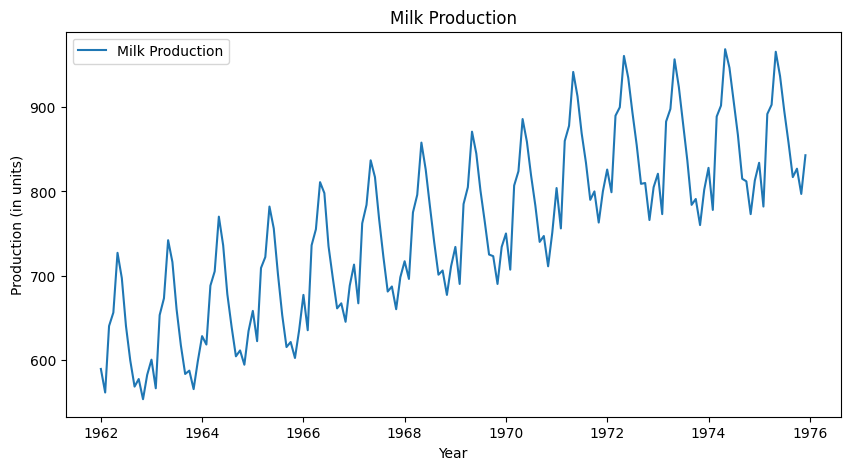

In [33]:
plt.figure(figsize=(10,5))
plt.plot(df['Production'], label='Milk Production')
plt.title('Milk Production')
plt.xlabel('Year')
plt.ylabel('Production (in units)')
plt.legend()
plt.show()

<Axes: title={'center': 'Residual Component (Anomalies/Noise)'}, xlabel='Date'>

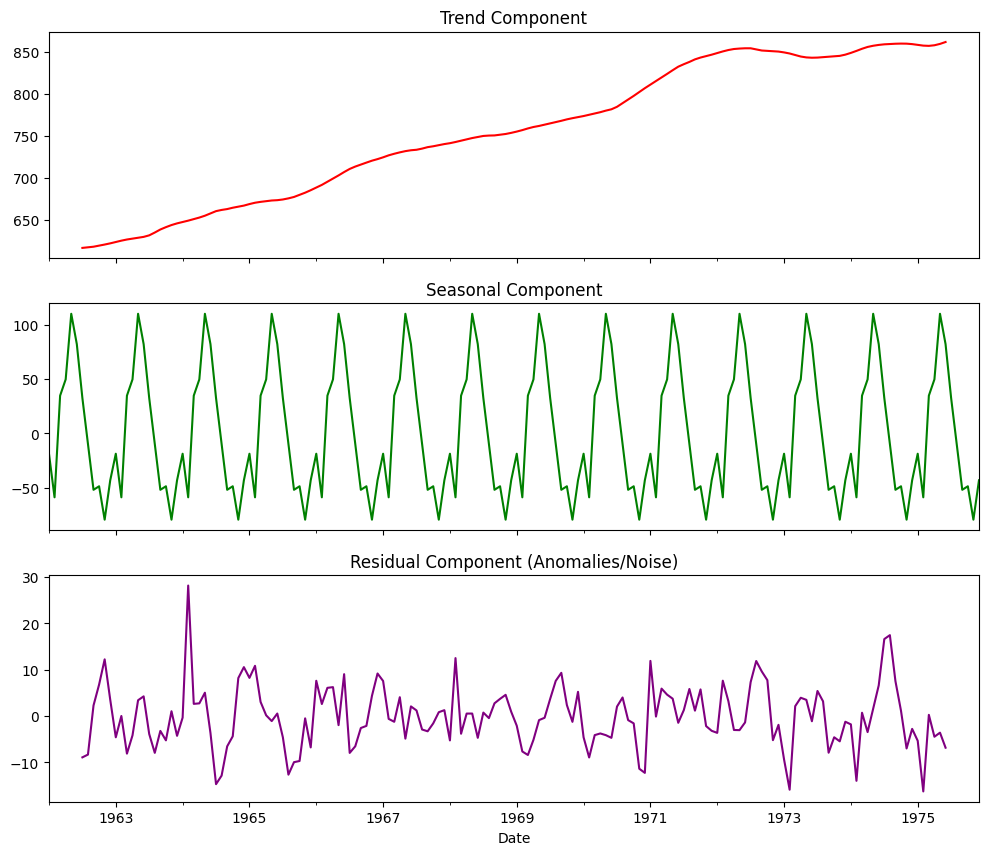

In [34]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
decomposition.trend.plot(ax=axes[0], title='Trend Component', color='red')
decomposition.seasonal.plot(ax=axes[1], title='Seasonal Component', color='green')
decomposition.resid.plot(ax=axes[2], title='Residual Component (Anomalies/Noise)', color='purple')

In [35]:
df.isnull().sum()

,0
Production,0


<Axes: >

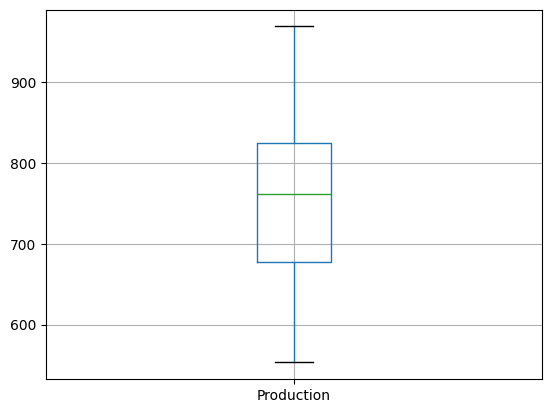

In [36]:
df.boxplot()

In [37]:
minmax=MinMaxScaler()

In [51]:
data_scaled = minmax.fit_transform(df)

In [52]:
df.head()

,Production
Date,
1962-01-01,0.086538
1962-02-01,0.019231
1962-03-01,0.209135
1962-04-01,0.247596
1962-05-01,0.418269


In [59]:
def create_sequences(data, window_size):
    x_train, y_train = [], []
    for i in range(window_size, len(data)):
        x_train.append(data[i-window_size:i, 0])
        y_train.append(data[i, 0])
    return np.array(x_train), np.array(y_train)


In [61]:
window = 12

x_train, y_train = create_sequences(data_scaled, window)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)


In [77]:
split = int(0.80 * len(x_train))

xtrain, x_test = x_train[:split], x_train[split:]
ytrain, y_test = y_train[:split], y_train[split:]

In [78]:
def build_model(model_type="RNN"):
    model = Sequential()

    if model_type == "RNN":
        model.add(SimpleRNN(64, return_sequences=False, input_shape=(window,1)))
    elif model_type == "LSTM":
        model.add(LSTM(64, return_sequences=False, input_shape=(window,1)))
    elif model_type == "GRU":
        model.add(GRU(64, return_sequences=False, input_shape=(window,1)))

    model.add(Dense(1))
    model.compile(optimizer=Adam(0.001), loss='mse')
    return model

In [79]:
model_rnn = build_model("RNN")
history_rnn = model_rnn.fit(xtrain, ytrain, epochs=50, batch_size=16, validation_split=0.1, verbose=0)

model_lstm = build_model("LSTM")
history_lstm = model_lstm.fit(xtrain, ytrain, epochs=50, batch_size=16, validation_split=0.1, verbose=0)

model_gru = build_model("GRU")
history_gru = model_gru.fit(xtrain, ytrain, epochs=50, batch_size=16, validation_split=0.1, verbose=0)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [80]:
pred_rnn = model_rnn.predict(x_test)
pred_lstm = model_lstm.predict(x_test)
pred_gru = model_gru.predict(x_test)

# inverse scaling
pred_rnn = minmax.inverse_transform(pred_rnn)
pred_lstm = minmax.inverse_transform(pred_lstm)
pred_gru = minmax.inverse_transform(pred_gru)

y_test_actual = minmax.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


In [81]:
def evaluate_model(actual, predicted):
    rmse = sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return rmse, mae, mape

In [82]:
rnn_scores = evaluate_model(y_test_actual, pred_rnn)
lstm_scores = evaluate_model(y_test_actual, pred_lstm)
gru_scores = evaluate_model(y_test_actual, pred_gru)

print("RNN:", rnn_scores)
print("LSTM:", lstm_scores)
print("GRU:", gru_scores)

RNN: (0.06365676208208382, 0.042281699639100334, np.float64(7.226132107226986))
LSTM: (0.07152172878370994, 0.060160394929922534, np.float64(12.28085051042825))
GRU: (0.11996567340611541, 0.09856349275662353, np.float64(17.899276008943367))


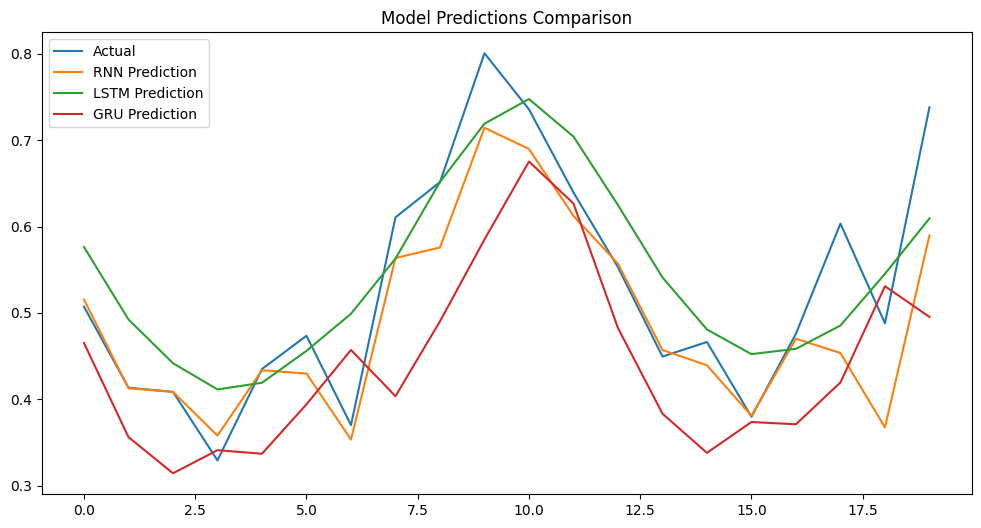

In [83]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual")
plt.plot(pred_rnn, label="RNN Prediction")
plt.plot(pred_lstm, label="LSTM Prediction")
plt.plot(pred_gru, label="GRU Prediction")
plt.title("Model Predictions Comparison")
plt.legend()
plt.show()

In [85]:
last_window = data_scaled[-window:]

future_predictions = []
current_input = last_window.reshape(1, window, 1)

for i in range(12):
    next_val = model_lstm.predict(current_input)[0][0]   # using best model: LSTM
    future_predictions.append(next_val)

    # update input window
    current_input = np.append(current_input[:,1:,:], [[[next_val]]], axis=1)

future_predictions = minmax.inverse_transform(np.array(future_predictions).reshape(-1,1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


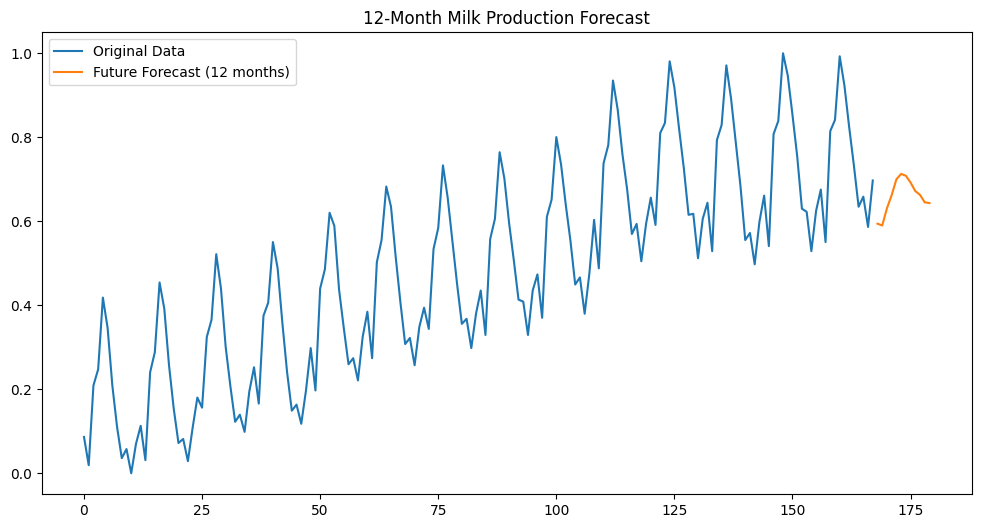

In [88]:
plt.figure(figsize=(12,6))
plt.plot(data, label="Original Data")
plt.plot(range(len(data), len(data)+12), future_predictions, label="Future Forecast (12 months)")
plt.title("12-Month Milk Production Forecast")
plt.legend()
plt.show()

the forecast for the next year is highly reliable, projecting continued growth and specifically highlighting the exact volume and timing of the high-production (summer peak) and low-production (winter trough) months.